<a href="https://colab.research.google.com/github/rulogar1234/nuclio-1/blob/develop/ML2_HOUSE_PRICING__Torneo_de_modelos%2C_Cross_validation%2C_y_Hiperparametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HOUSE PRICING: Cross-validation, Competicion ML y Hiperparametros**

**TAREA: REGRESIÓN**<br>
**NIVEL: INTERMEDIATE**
<br>
Vamos a realizar un torneo de modelos con algunos modelos de regresión. Para ello utilizaremos un dataset de precios de propiedades en Ames, Iowa.

# Librerias

In [70]:
# Datos
import numpy as np
import pandas as pd

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from random import random

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

# Evaluacion
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

#Tamño default de los plots
plt.rcParams["figure.figsize"] = [10,6]

# Load dataset

Dataset source: https://www.perkinsml.me/ames-housing

El dataset House_Pricing contiene datos de compra-venta de viviendas  en Ames, Iowa recopilados por una agencia inmobiliaria:
* Precio (dolares)
* Area vivienda (m2)
* Antiguedad vivienda (años)
* Numero de Habitaciones
* Numero de Dormitorios
* Ingresos promedio de la zona (dolares)
* Densidad poblacional (hab/km2)

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/House_Pricing_Ames.csv')
df.head(10)

,PRECIO,AREA,ANTIGUEDAD,HABITACIONES,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
0,317710.2,243.18,5.68,7.0,4.0,79545.46,23086.80
1,451767.3,234.83,6.00,7.0,3.0,79248.64,40173.07
2,317696.4,288.28,5.87,9.0,5.0,61287.07,36882.16
3,378185.1,200.50,7.19,6.0,3.0,63345.24,34310.24
4,189282.9,268.08,5.04,8.0,4.0,59982.20,26354.11
5,320441.4,216.04,4.99,6.0,4.0,80175.75,26748.43
6,450616.8,277.33,6.03,8.0,3.0,64698.46,60828.25
7,472181.1,231.52,6.99,7.0,2.0,78394.34,36516.36
8,239661.0,224.69,5.36,6.0,2.0,59927.66,29387.40
9,463546.5,277.93,4.42,8.0,6.0,81885.93,40149.97


In [73]:
df.shape

(5000, 7)

# ML PREPROCESSING

### Data cleaning

EN los nulos aplicamos outlayers, (numerios que esten fuera de la media como números negativos)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PRECIO          5000 non-null   float64
 1   AREA            5000 non-null   float64
 2   ANTIGUEDAD      5000 non-null   float64
 3   HABITACIONES    5000 non-null   float64
 4   DORMITORIOS     5000 non-null   float64
 5   INGRESOS_ZONA   5000 non-null   float64
 6   POBLACION_ZONA  5000 non-null   float64
dtypes: float64(7)
memory usage: 273.6 KB


In [75]:
#Corregimos formatos
df.HABITACIONES = df.HABITACIONES.astype('int8')
df.DORMITORIOS = df.DORMITORIOS.astype('int8')

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PRECIO          5000 non-null   float64
 1   AREA            5000 non-null   float64
 2   ANTIGUEDAD      5000 non-null   float64
 3   HABITACIONES    5000 non-null   int8   
 4   DORMITORIOS     5000 non-null   int8   
 5   INGRESOS_ZONA   5000 non-null   float64
 6   POBLACION_ZONA  5000 non-null   float64
dtypes: float64(5), int8(2)
memory usage: 205.2 KB


In [77]:
# Check duplicados (no hjay outlayers)
df.duplicated().sum()

0

In [78]:
# Check filas sin target, si el target es nulo lo borramos
df['PRECIO'].isna().sum()

0

### EDA: Análisis exploratorio

* **texto en negrita** En datasets con POCAS VARIABLES (como es el caso) podemos permitirnos explorar visualmente las distribuciones de las variables (analisis univariable) y de las relaciones entre variables (analisis multivariable) para tener mas conocimiento de los datos.
* En datasets con MUCHAS VARIABLES (>20) obviaremos este paso pues el analisis visual se vuelve complejo y no ayuda.

In [79]:
target = 'PRECIO'
features = df.columns[df.columns!=target]

In [80]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRECIO,5000.0,369621.797640,105935.287688,4781.70,299273.1750,369800.700,441363.0000,740719.80
AREA,5000.0,242.534648,30.175065,129.99,221.8775,242.990,262.8775,355.69
ANTIGUEDAD,5000.0,5.977278,0.991437,2.64,5.3200,5.970,6.6500,9.52
HABITACIONES,5000.0,6.988400,1.044262,3.00,6.0000,7.000,8.0000,11.00
DORMITORIOS,5000.0,3.741200,1.228057,2.00,3.0000,4.000,4.0000,6.00
INGRESOS_ZONA,5000.0,68583.108950,10657.991228,17796.63,61480.5650,68804.285,75783.3425,107701.75
POBLACION_ZONA,5000.0,36163.516088,9925.650059,172.61,29403.9300,36199.405,42861.2900,69621.71


In [81]:
target = 'PRECIO'
features = df.columns[df.columns!=target]

# Divide dataset en matriz de variables (X) y output (y)
X = df[features]
y = df[target]

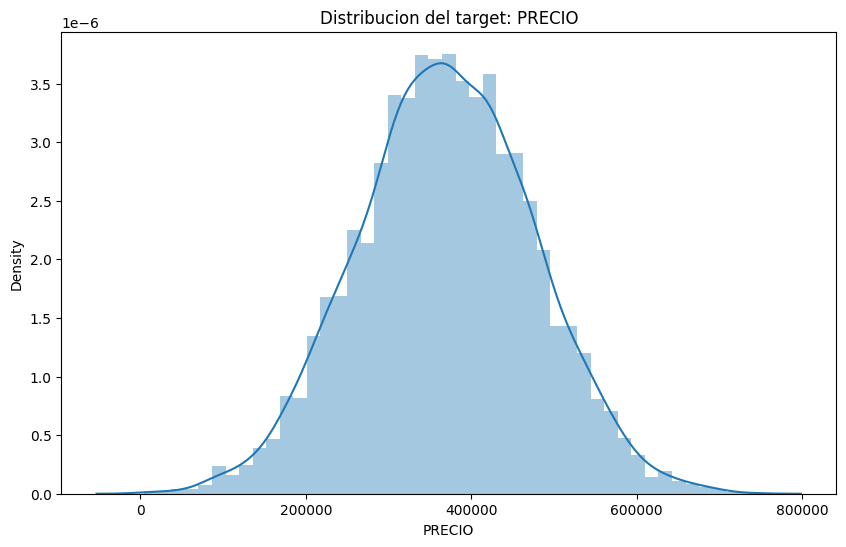

In [82]:
#Distribucion target
sns.distplot(y)
plt.title('Distribucion del target: '+target)
plt.show()

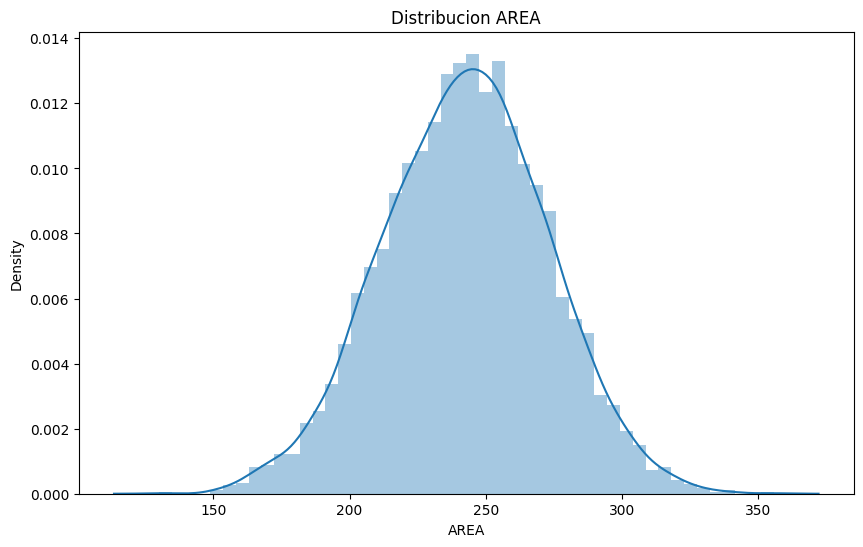

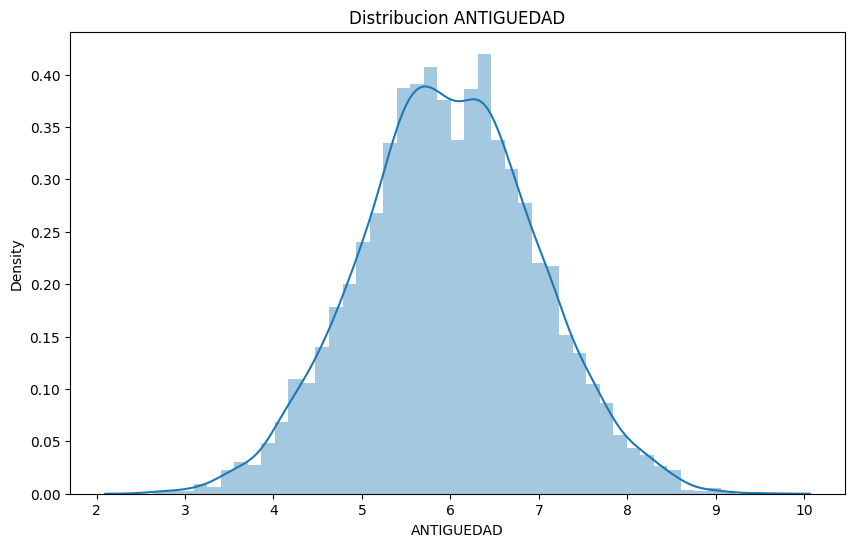

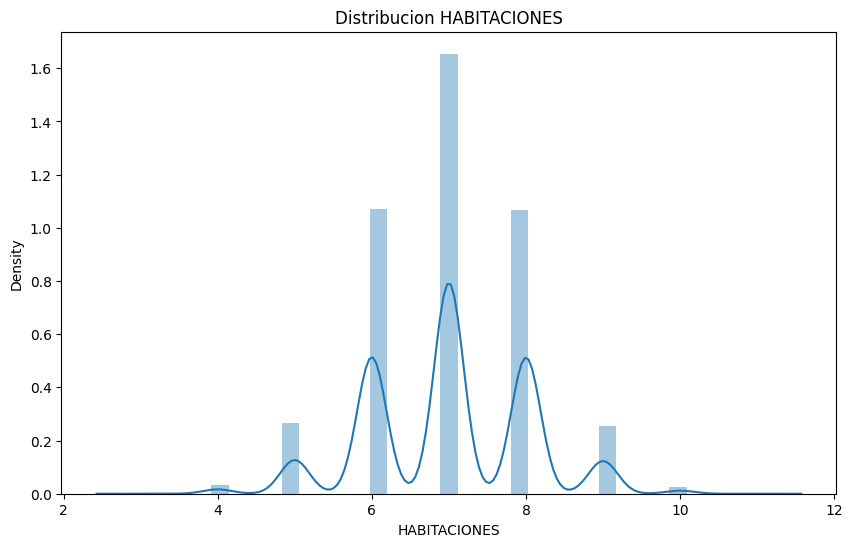

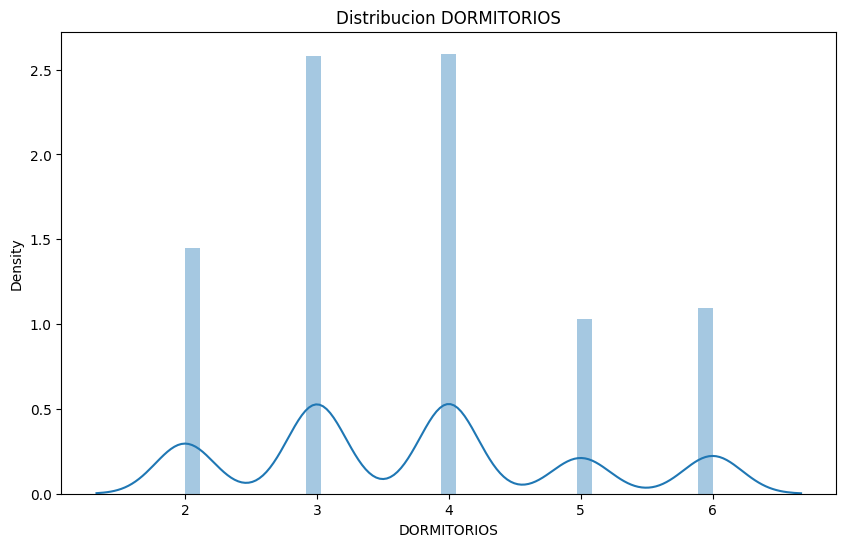

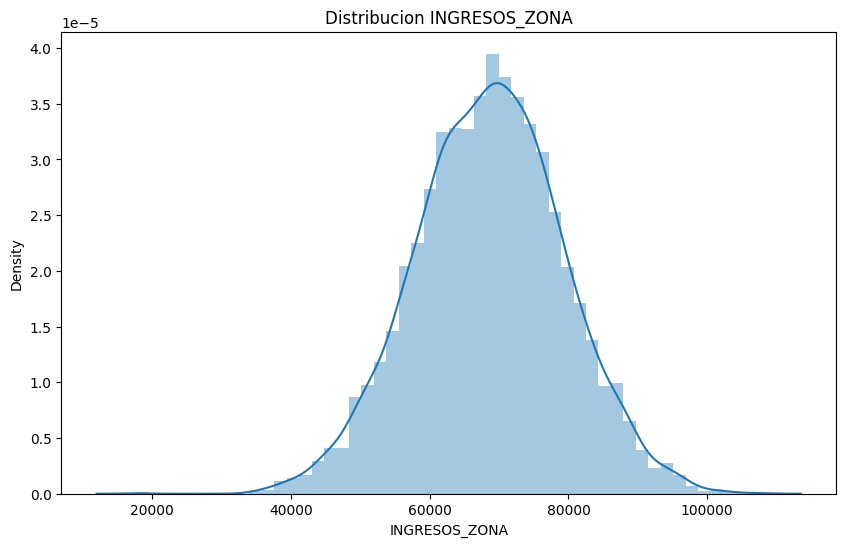

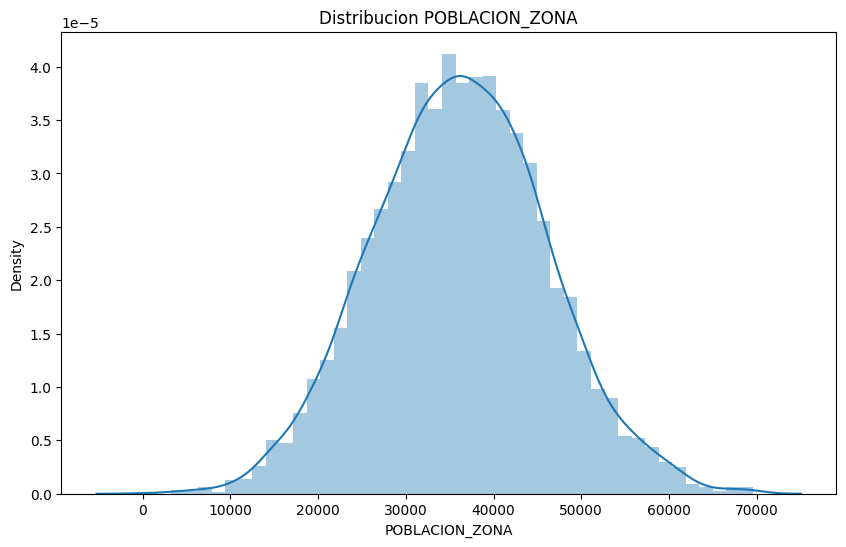

In [83]:
for i in features:
  sns.distplot(X[i])
  plt.title('Distribucion '+i)
  plt.show()

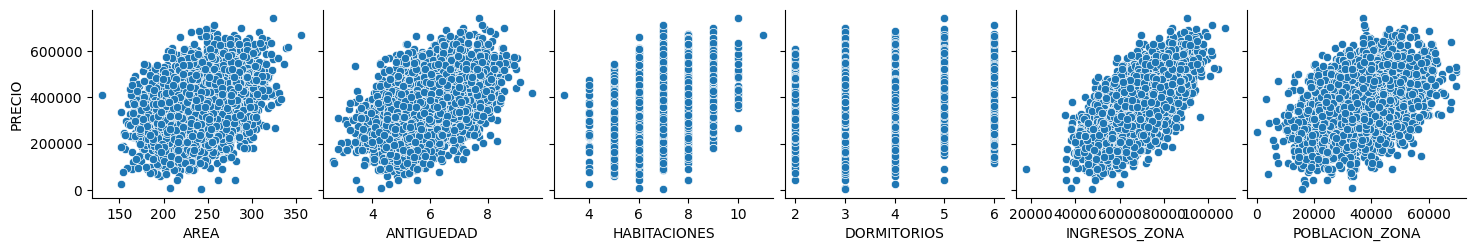

In [84]:
#Dispersion target-variable, si el dataset es pequeño podemos hacer este tipo de gráficos, comparamos el target con le resto de variables,
#Vemos correlaciones, por ejemplo se ve que a más ingresos zona mayor precio
sns.pairplot(df,x_vars=features, y_vars=target)
plt.show()

### Imputar nulos

In [85]:
#no hay nulos, en los modelos de reglas lo mejor es meter outlayers
df.isna().sum()

PRECIO            0
AREA              0
ANTIGUEDAD        0
HABITACIONES      0
DORMITORIOS       0
INGRESOS_ZONA     0
POBLACION_ZONA    0
dtype: int64

In [86]:
#no hay nulos, en los modelos de reglas lo mejor es meter outlayers, por ejemplo lo mejor es montarnos un diccionario con valores aoutlayers
values_to_input= {
    "AREA": -999,
    "ANTIGUEDAD": -999,
    "HABITACIONES": -999,
    "DORMITORIOS": -999,
    "INGRESOS_ZONA": -999,
    "POBLACION_ZONA": -999
}

In [87]:
df.fillna(values_to_input)

,PRECIO,AREA,ANTIGUEDAD,HABITACIONES,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
0,317710.2,243.18,5.68,7,4,79545.46,23086.80
1,451767.3,234.83,6.00,7,3,79248.64,40173.07
2,317696.4,288.28,5.87,9,5,61287.07,36882.16
3,378185.1,200.50,7.19,6,3,63345.24,34310.24
4,189282.9,268.08,5.04,8,4,59982.20,26354.11
...,...,...,...,...,...,...,...
4995,318058.2,217.02,7.83,6,3,60567.94,22837.36
4996,444785.4,230.20,7.00,7,4,78491.28,25616.12
4997,309219.0,177.05,7.25,5,2,63390.69,33266.15
4998,359597.1,246.81,5.53,7,5,68001.33,42625.62


## Encoding categoricos

In [88]:
# No hay categoricos, no hay que hacer encoding

## Eliminar alta correlación

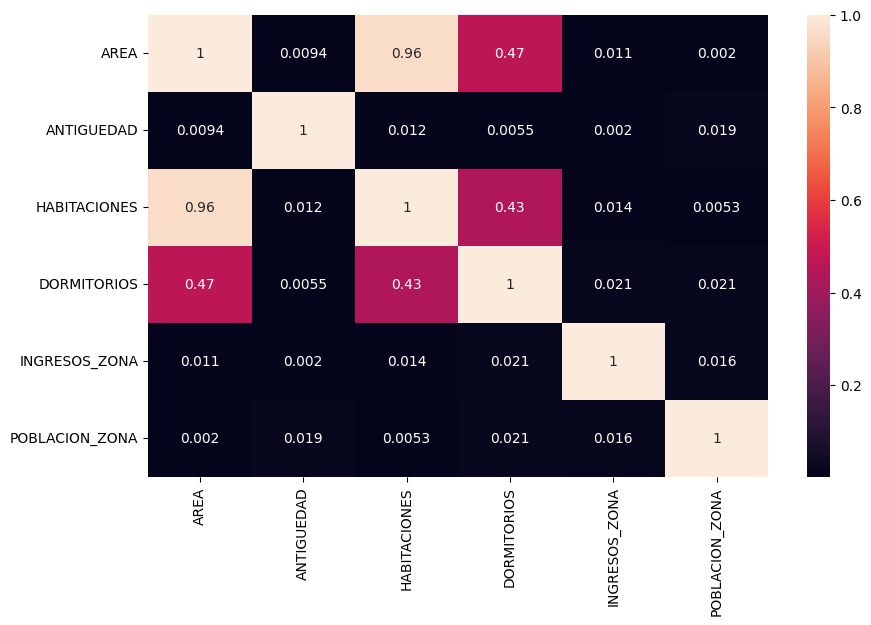

In [89]:
sns.heatmap(X.corr().abs(),annot=True)
plt.show()

In [90]:
# Mismo analisis, pero desde una funcion que nos facilita la vida para encontrar la máxima correlación
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

highly_corr = highly_correlated(X,y,0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,HABITACIONES,AREA,0.961175,0.321108,0.335664,HABITACIONES


In [91]:
list(highly_corr['F_to_delete'])

['HABITACIONES']

In [92]:
# Eliminamos las features altamente correlacionadas
drop_cols = list(highly_corr['F_to_delete'])
X.drop(columns=drop_cols, inplace=True)
print('Eliminadas columnas altamente correlacionadas:', drop_cols)

Eliminadas columnas altamente correlacionadas: ['HABITACIONES']


In [93]:
X.head(3)

,AREA,ANTIGUEDAD,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
0,243.18,5.68,4,79545.46,23086.80
1,234.83,6.00,3,79248.64,40173.07
2,288.28,5.87,5,61287.07,36882.16


## Eliminar baja varianza

In [94]:
# Eliminamos columnas prácticamente constantes (nula varianza), si el 99% de los valores son iguales este step te los filtra
vt = VarianceThreshold(threshold = 0.01)
vt.fit(X)

cols_lowvar = X.columns[vt.get_support()==False]
X.drop(columns=cols_lowvar,inplace=True)

print(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar.to_list())

0  low variance features were removed:
 []


In [95]:
vt.transform(X)

array([[2.431800e+02, 5.680000e+00, 4.000000e+00, 7.954546e+04,
        2.308680e+04],
       [2.348300e+02, 6.000000e+00, 3.000000e+00, 7.924864e+04,
        4.017307e+04],
       [2.882800e+02, 5.870000e+00, 5.000000e+00, 6.128707e+04,
        3.688216e+04],
       ...,
       [1.770500e+02, 7.250000e+00, 2.000000e+00, 6.339069e+04,
        3.326615e+04],
       [2.468100e+02, 5.530000e+00, 5.000000e+00, 6.800133e+04,
        4.262562e+04],
       [2.366700e+02, 5.990000e+00, 4.000000e+00, 6.551058e+04,
        4.650128e+04]])

# TRAIN

## Split train-test

Para el test dejamos entre un 10%-30% del dataset original. 10% cuando el dataset es pequeño (<10k), 20-30% cuando el dataset es grande (>100k).

In [96]:
# Divide X-y en Train (85%) y Test (15%) (15% porque el dataset es pequeño)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [97]:
print('Train set size:',X_train.shape[0])
print('Test set size:',X_test.shape[0])

Train set size: 4250
Test set size: 750


## Rescaling

In [98]:
# Estandarización: fit_transform() en train, transform() en test, estandard scaling se usa cuando los datos no sean tan sensibles a outlayers
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns, index= X_test.index)

In [99]:
X_train.head(3)

,AREA,ANTIGUEDAD,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
2347,245.40,7.51,3,51168.43,30369.19
3439,235.45,8.24,3,83648.23,21137.03
4998,246.81,5.53,5,68001.33,42625.62


In [100]:
X_train_std.head(3)

,AREA,ANTIGUEDAD,DORMITORIOS,INGRESOS_ZONA,POBLACION_ZONA
2347,0.098458,1.552525,-0.611406,-1.631198,-0.573929
3439,-0.229767,2.289994,-0.611406,1.409917,-1.500896
4998,0.144970,-0.447735,1.023369,-0.055117,0.656694


## Torneo de Modelos

**K-Fold Cross validation**<br>
Devuelve el predict promedio de k modelos entrenados con distintas particiones para el test. Es más fiable y robusto sobre todo en datasets pequeños.

* La metrica del score la dicta cada modelo. Ver documentacion de cada modelo en scikitlearn para saber qué metrica es el score. Por defecto en regresion suele ser el R2-score pero podemos utilizar otras metricas: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [102]:
#cv es el K (número de particiones), scoring es la métrica que queremos que mida, en este caso es el Negative RSME, por eso lo ponemos negativo delante
-cross_val_score(model, X_train, y_train, cv=4, scoring='neg_root_mean_squared_error')

array([29829.07625809, 31003.11645101, 30684.15419973, 29870.05467906])

In [103]:
#cáculamos la media del RSME
model = LinearRegression()
np.mean(-cross_val_score(model, X_train, y_train, cv=4, scoring='neg_root_mean_squared_error'))

30346.6003969735

Para la proxima parte vamos a crear funciones que nos ayuden a evaluar el error rapidamente en los diferentes modelos:

In [104]:
# Modelos ML de Regresion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

In [105]:
#calculamosel RSME en ttrain
def RMSE(model,X,y):
  model.fit(X,y)
  return round(np.sqrt(np.mean((y-model.predict(X))**2)),2)

#RSME en validación
def RMSE_cross_validation(model,X,y):
  Kfold_rmse = cross_val_score(model, X, y, cv=4, scoring='neg_root_mean_squared_error')
  return round(-Kfold_rmse.mean(),4)

In [106]:
# Inicializa resultados
label_ = []
rmse_train_ = []
rmse_valida_ = []

# Funcion que devuelve un dataframe con resultados de RMSE Cross Validation
def evaluate_regression(model, X, y, label=None):
  if label is None:
    label = str(model)

  rmse_train = RMSE(model,X,y)
  rmse_valida = RMSE_cross_validation(model,X,y)

  label_.append(label)
  rmse_train_.append(rmse_train)
  rmse_valida_.append(rmse_valida)

  return pd.DataFrame({'Model': label_,
                      'RMSE Train': rmse_train_,
                      'RMSE Cross-Validation': rmse_valida_
                      }).sort_values('RMSE Cross-Validation')

In [107]:
evaluate_regression(model = LinearRegression(),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),30270.63,30346.6004


**Regresión Lineal + Regularización: LASSO, Ridge y ElasticNet**

In [108]:
#LAsso nos proteg del overfitting
evaluate_regression(model = Lasso(alpha=1),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004


In [109]:
evaluate_regression(model = Ridge(alpha=10),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812


In [110]:
#Lasso practicamente no corrige overfiting, gana la regresion lineal, menor mejor
evaluate_regression(model = ElasticNet(l1_ratio=0.5),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
3,ElasticNet(),45875.62,45941.5436


**Polynomial Regression**

In [111]:
poly_reg = PolynomialFeatures(degree=2)

#Trasformamos el dato para que la ecuacion de la regresion lineal se ajuste a una expresion polinomica: X^3 + X^2 + X + 1
X_train_poly = poly_reg.fit_transform(X_train_std)

In [112]:
#El dataset será mucho más grande porque lo ajusta a un modelo de polinomio de un grado.
X_train_poly.shape

(4250, 21)

In [113]:
evaluate_regression(label='Polynomial 2d',
                    model = LinearRegression(),
                    X=X_train_poly, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
4,Polynomial 2d,30239.63,30462.3123
3,ElasticNet(),45875.62,45941.5436


In [114]:
poly_reg = PolynomialFeatures(degree=5)

#Trasformamos el dato para que la ecuacion de la regresion lineal se ajuste a una expresion polinomica: X^3 + X^2 + X + 1
X_train_poly = poly_reg.fit_transform(X_train_std)

In [115]:
#El dataset será mucho más grande porque lo ajusta a un modelo de polinomio de un grado.
X_train_poly.shape

(4250, 252)

In [116]:
evaluate_regression(label='Polynomial 5d',
                    model = LinearRegression(),
                    X=X_train_poly, y=y_train)
#vemos que cuanto más grado tenga la regresion lineal mejor valor en train y peor en validación, es overfitting

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
4,Polynomial 2d,30239.63,30462.3123
5,Polynomial 5d,29395.81,32856.4395
3,ElasticNet(),45875.62,45941.5436


In [117]:
#apara evitar el overfiting se puede usar la técnica de los la regularización, para eso se usa LAsso y Ridge
#Lasso elimina los coeficientes menos relevantes Ridge los deja aún más pequeños

**Stochastic Gradient Descent**

In [ ]:
evaluate_regression(model = SGDRegressor(n_iter_no_change=1000, penalty=None, eta0=0.01, max_iter=10000),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
6,"SGDRegressor(max_iter=10000, n_iter_no_change=...",30270.85,30351.8324
4,Polynomial 2d,30239.63,30462.3123
5,Polynomial 5d,29395.81,32856.4395
3,ElasticNet(),45875.62,45941.5436


**Naive-Bayes**

In [118]:
from sklearn.gaussian_process import GaussianProcessRegressor

evaluate_regression(model = GaussianProcessRegressor(),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
4,Polynomial 2d,30239.63,30462.3123
5,Polynomial 5d,29395.81,32856.4395
3,ElasticNet(),45875.62,45941.5436
6,GaussianProcessRegressor(),0.00,383865.1925


**KNN Regressor**

In [119]:
evaluate_regression(model = KNeighborsRegressor(n_neighbors = 3),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
4,Polynomial 2d,30239.63,30462.3123
5,Polynomial 5d,29395.81,32856.4395
7,KNeighborsRegressor(n_neighbors=3),28449.73,41484.7477
3,ElasticNet(),45875.62,45941.5436
6,GaussianProcessRegressor(),0.00,383865.1925


**Random Forest Regressor**

In [120]:
evaluate_regression(model = RandomForestRegressor(n_estimators=100, max_depth=3),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
4,Polynomial 2d,30239.63,30462.3123
5,Polynomial 5d,29395.81,32856.4395
7,KNeighborsRegressor(n_neighbors=3),28449.73,41484.7477
3,ElasticNet(),45875.62,45941.5436
8,RandomForestRegressor(max_depth=3),65519.49,66801.4886
6,GaussianProcessRegressor(),0.00,383865.1925


**XGBoost Regressor**

In [121]:
evaluate_regression(model = XGBRegressor(objective ='reg:squarederror'),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
1,Lasso(alpha=1),30270.63,30346.5990
0,LinearRegression(),30270.63,30346.6004
2,Ridge(alpha=10),30271.66,30348.0812
4,Polynomial 2d,30239.63,30462.3123
5,Polynomial 5d,29395.81,32856.4395
9,"XGBRegressor(base_score=None, booster=None, ca...",15286.91,37300.8920
7,KNeighborsRegressor(n_neighbors=3),28449.73,41484.7477
3,ElasticNet(),45875.62,45941.5436
8,RandomForestRegressor(max_depth=3),65519.49,66801.4886
6,GaussianProcessRegressor(),0.00,383865.1925


**NOTA:** Tambien se probó una Red Neuronal ANN y el resultado en validación fue RMSE = 127,795.59 ...

## Hiperparametros

Vamos a utilizar RandomSearch para obtener la mejor configuración del modelo ganador: el Stochastic Gradient Descent (SGD).

In [122]:

from sklearn.model_selection import RandomizedSearchCV

In [123]:
#Vamos a hacer con varias pruebas de hiperparametización
SGDRegressor?

In [124]:
#regularizar es luchar contra el overfiting (Alpha)
#penalty l1 lasso l2 ridge
parameters_hp = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': [None,'l1','l2'],
    'alpha': [0.0001, 0.01, 0.1,0.3,0.5],
    'l1_ratio': [0.15, 0.5],
    'max_iter': [1000, 5000, 10000],
    'learning_rate': ['invscaling', 'optimal', 'adaptative'],
    'eta0': [0.01,0.05,0.1],
    'early_stopping': [True, False],
    'n_iter_no_change': [5,10,30]
}

In [125]:
#configuración de la hiperparametrización
search_hp = RandomizedSearchCV(estimator=SGDRegressor(),
                               param_distributions = parameters_hp,
                               scoring='neg_root_mean_squared_error',     # metrica a optimizar: RMSE
                               cv = 4,                                    # numero de folds para cross-validation
                               n_iter = 50,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               verbose=True)

In [126]:
search_hp.fit(X_train_std, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=4, estimator=SGDRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.01, 0.1, 0.3, 0.5],
                                        'early_stopping': [True, False],
                                        'eta0': [0.01, 0.05, 0.1],
                                        'l1_ratio': [0.15, 0.5],
                                        'learning_rate': ['invscaling',
                                                          'optimal',
                                                          'adaptative'],
                                        'loss': ['squared_error', 'huber',
                                                 'epsilon_insensitive'],
                                        'max_iter': [1000, 5000, 10000],
                                        'n_iter_no_change': [5, 10, 30],
                                        'penalty': [None, 'l1', 'l2']},
                   scoring='neg_root_mean_squared_error', verbose=True)

In [128]:
search_hp.best_estimator_

SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='optimal',
             max_iter=10000, n_iter_no_change=10, penalty='l1')

In [129]:
search_hp.best_score_

-30342.50061402346

In [127]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best RMSE:", -search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: SGDRegressor(alpha=0.1, early_stopping=True, learning_rate='optimal',
             max_iter=10000, n_iter_no_change=10, penalty='l1')

 The best RMSE: 30342.50061402346

 The best parameters across ALL searched params:
 {'penalty': 'l1', 'n_iter_no_change': 10, 'max_iter': 10000, 'loss': 'squared_error', 'learning_rate': 'optimal', 'l1_ratio': 0.15, 'eta0': 0.01, 'early_stopping': True, 'alpha': 0.1}


El unico problema de RandomSearch es que no podemos elegir las configuraciones a probar y podria dar con un ajuste de parametros que no es mejor que la configuración por defecto. Asi que es recomendable siempre comprobar que se mejora el  performance que se obtuvo con la configuracion default en la Competicion de Modelos.

## Modelo final

In [131]:
model = search_hp.best_estimator_

In [ ]:
#ALTERNATIVA: el modelo por defecto que tiene unos parámetros que suelen ir bien, de hecho la estimación ha sido mejor en nuestro caso (ejecución en clase)
#model = SGDRegressor()
#model.fit(X_train_std)

# TEST

### Evaluación del error

Veamos en detalle el error que produce el modelo en los datos de Test

In [132]:
y_train_pred = model.predict(X_train_std)              # predicciones del modelo en los datos de TRAIN
y_test_pred = model.predict(X_test_std)                # predicciones del modelo en los datos de TEST

* **RMSE, MAE y MAPE**

In [133]:
error = y_test_pred - y_test.values

In [134]:
mae = np.mean(np.abs(error))
mape = np.mean(error/y_test)
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('MAPE: {:.3%}'.format(mape))
print('R2-Score: {:.2%}'.format(r2_score(y_test, y_test_pred)))

RMSE: 30669.8171
MAE: 24665.9975
MAPE: 0.878%
R2-Score: 91.48%


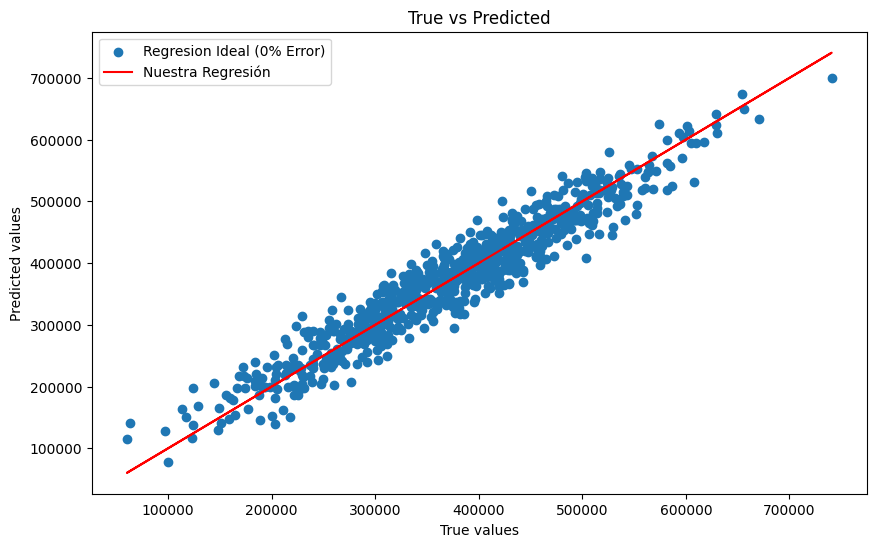

In [135]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(y_test,y_test_pred)
plt.plot(y_test,y_test,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

**Distribución del error**

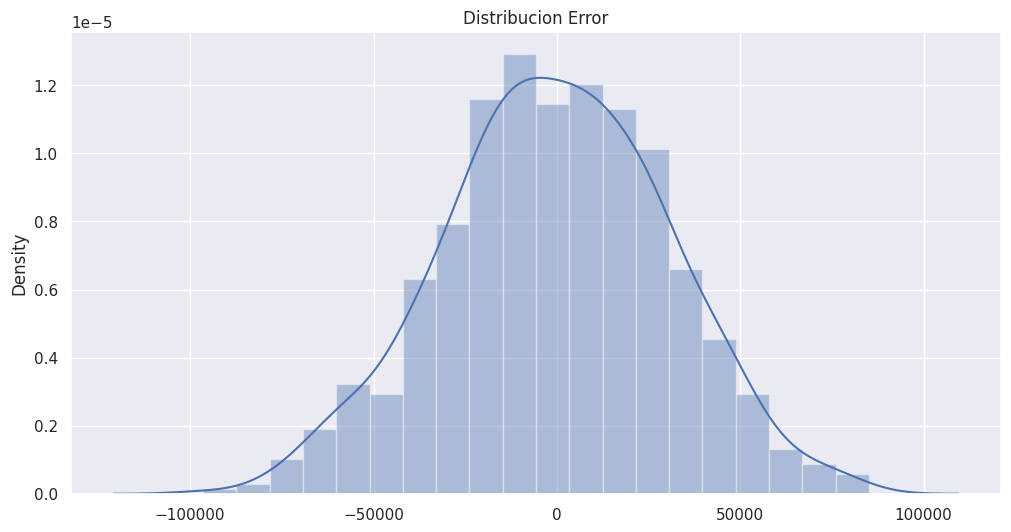

In [136]:
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

In [137]:
round(pd.Series(error).describe(),2)

count      750.00
mean      -442.75
std      30687.09
min     -96461.46
25%     -20546.85
50%       -587.39
75%      20694.30
max      85076.17
dtype: float64

**Error interval:**

In [138]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 57712.0 / -62056.2


# Interpretabilidad

Como el dataset fue estandarizado, los coeficientes resultantes de la regresion lineal corresponden a la importancia de cada variable en el resultado del modelo.

In [139]:
model.coef_

array([36299.15461327, 48810.86943785,   563.83486843, 69408.17809259,
       45441.53381225])

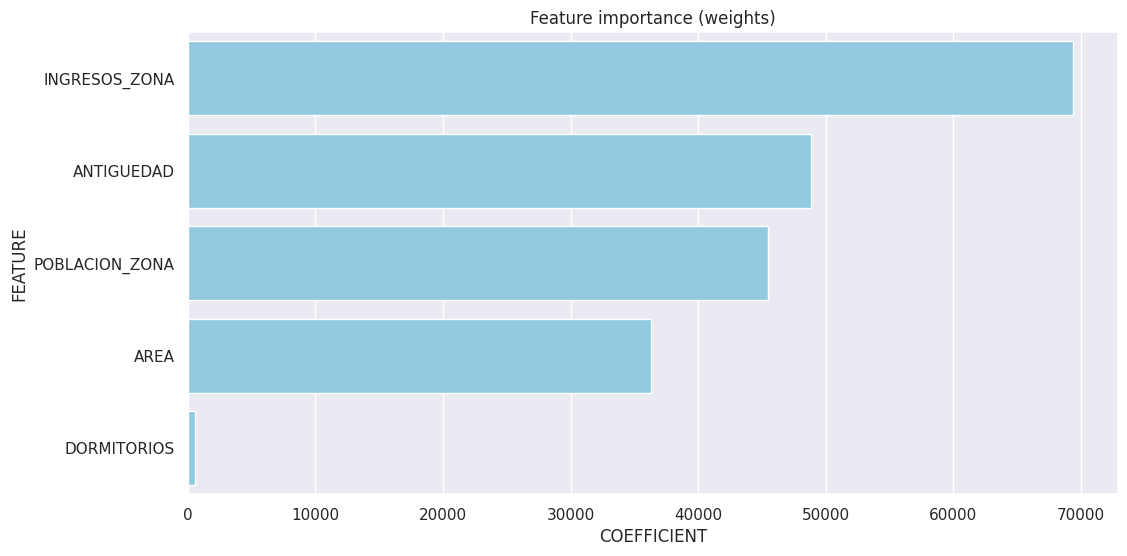

In [141]:
df_coef = pd.DataFrame({'FEATURE':X.columns.values,
            'COEFFICIENT': model.coef_}).sort_values('COEFFICIENT',ascending=False)
sns.barplot(data=df_coef, y='FEATURE',x='COEFFICIENT',color='skyblue')
plt.title('Feature importance (weights)')
plt.show()

In [142]:
df_coef

,FEATURE,COEFFICIENT
3,INGRESOS_ZONA,69408.178093
1,ANTIGUEDAD,48810.869438
4,POBLACION_ZONA,45441.533812
0,AREA,36299.154613
2,DORMITORIOS,563.834868


# PREDICT

In [143]:
X_train.columns

Index(['AREA', 'ANTIGUEDAD', 'DORMITORIOS', 'INGRESOS_ZONA', 'POBLACION_ZONA'], dtype='object')

In [144]:
x = [120, 10, 4, 40000, 30000]   #Variables

In [145]:
x_std = scaler.transform(np.array(x).reshape(1, -1))

In [146]:
x_std

array([[-4.03816965,  4.06800329,  0.20598169, -2.67690904, -0.61099779]])

In [147]:
model.predict(x_std)

array([207288.93742689])